In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

In [2]:
ames_housing = pd.read_csv('C:/Users/Process Research/Downloads/Springboard Assignments/House Prices Advanced Regression Techniques/train.csv')
ames_housing_e = ames_housing.set_index('Id')
ames_housing_e.head().T

Id,1,2,3,4,5
MSSubClass,60,20,60,70,60
MSZoning,RL,RL,RL,RL,RL
LotFrontage,65,80,68,60,84
LotArea,8450,9600,11250,9550,14260
Street,Pave,Pave,Pave,Pave,Pave
...,...,...,...,...,...
MoSold,2,5,9,2,12
YrSold,2008,2007,2008,2006,2008
SaleType,WD,WD,WD,WD,WD
SaleCondition,Normal,Normal,Normal,Abnorml,Normal


Next, the data will be partitioned into training & testing splits, without letting a model (or missing-value imputation) learn about the test split, getting a somewhat independent assessment of how the model might perform in the future.

Next will be assessing what partition sizes would be gotten from a 70/30 train/test split.

In [3]:
ames_housing_nums = ames_housing_e.select_dtypes(['number'])

In [101]:
len(ames_housing_nums) * .7, len(ames_housing_nums) * .3

(1021.9999999999999, 438.0)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(ames_housing_nums.drop(columns='SalePrice'), 
                                                    ames_housing_nums.SalePrice, test_size=0.3, 
                                                    random_state=47)

In [6]:
X_train.shape, X_test.shape

((1022, 36), (438, 36))

In [7]:
y_train.shape, y_test.shape

((1022,), (438,))

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1022 entries, 1351 to 1160
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1022 non-null   int64  
 1   LotFrontage    845 non-null    float64
 2   LotArea        1022 non-null   int64  
 3   OverallQual    1022 non-null   int64  
 4   OverallCond    1022 non-null   int64  
 5   YearBuilt      1022 non-null   int64  
 6   YearRemodAdd   1022 non-null   int64  
 7   MasVnrArea     1016 non-null   float64
 8   BsmtFinSF1     1022 non-null   int64  
 9   BsmtFinSF2     1022 non-null   int64  
 10  BsmtUnfSF      1022 non-null   int64  
 11  TotalBsmtSF    1022 non-null   int64  
 12  1stFlrSF       1022 non-null   int64  
 13  2ndFlrSF       1022 non-null   int64  
 14  LowQualFinSF   1022 non-null   int64  
 15  GrLivArea      1022 non-null   int64  
 16  BsmtFullBath   1022 non-null   int64  
 17  BsmtHalfBath   1022 non-null   int64  
 18  FullB

In [9]:
train_mean = y_train.mean()
train_mean

181438.98140900195

Below, will use the predict feature

In [10]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[181438.981409]])

A good place to start is to see how good the mean is as a predictor. In other words, the best guess may be the average price.

sklearn's DummyRegressor easily does this.

These closely match the actual values. There are many ways of assessing how good one set of values agrees with another.

Next up will be an assessment of the metrics. $R^2$, the coefficient of determination, will be used to predict whether we get a negative or positive answer, a positive answer meaning it perfectly predicts the observed values with no residual error ($R^2=1$). Models that do worse than predicting the mean will have increased the sum of squares of residuals and so produce a negative $R^2$.

In [11]:
def r_squared(y, ypred):
    """R-squared score.
     
     ypred = vector of predicted values
     y = vector of actual values
         SHOULD HAVE SAME LENGTH
     
    Calculate the R-squared, or coefficient of determination, of the input.
    
    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    ybar = np.sum(y) / len(y) 
    sum_sq_tot = np.sum((y - ybar)**2) 
    sum_sq_res = np.sum((y - ypred)**2)
    R2 = 1.0 - sum_sq_res / sum_sq_tot
    return R2

In [12]:
y_tr_pred_ = train_mean * np.ones(len(y_train))
y_tr_pred_[:5]

array([181438.981409, 181438.981409, 181438.981409, 181438.981409,
       181438.981409])

In [13]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([181438.981409, 181438.981409, 181438.981409, 181438.981409,
       181438.981409])

The DummyRegressor produces exactly the same results and saves having to mess about broadcasting the mean (or whichever other statistic used) to an array of the appropriate length. It also gives an object with fit() and predict() methods as well to use them as conveniently as any other sklearn estimator.

In [14]:
r_squared(y_train, y_tr_pred)

0.0

As expected, using the average value as the prediction, an $R^2$ of zero is attained on the training set. The "model" is trained on the training set; still need to use the training set mean as the prediction.

Make predictions by creating an array of length the size of the test set with the single value of the (training) mean.

In [15]:
y_te_pred = train_mean * np.ones(len(y_test))
r_squared(y_test, y_te_pred)

-0.00046137014159541856

Generally, the performance on a test set is to be slightly worse than on the training set. After getting an $R^2$ of zero on the training set, there's nowhere to go but negative.

In [16]:
def mae(y, ypred):
    """Mean absolute error.
    
    Calculate the mean absolute error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    abs_error = np.abs(y - ypred)
    mae = np.mean(abs_error)
    return mae

In [17]:
mae(y_train, y_tr_pred)

57099.59344518414

In [18]:
mae(y_test, y_te_pred)

58634.20749001425

Mean absolute error is arguably the most intuitive of all the metrics, essentially saying, on average, one might expect to be off by around $58634.21 if you guessed ticket price based on an average of known values.



In [19]:
def mse(y, ypred):
    """Mean square error.
    
    Calculate the mean square error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    sq_error = (y - ypred)**2
    mse = np.mean(sq_error)
    return mse

In [20]:
mse(y_train, y_tr_pred)

6241665020.450732

In [21]:
mse(y_test, y_te_pred)

6459637242.923498

So here, you get a slightly better MSE on the test set than you did on the train set. And what does a squared error mean anyway? To convert this back to our measurement space, we often take the square root, to form the root mean square error thus:



In [22]:
np.sqrt([mse(y_train, y_tr_pred), mse(y_test, y_te_pred)])

array([79004.20887808, 80371.86847973])

sklearn metrics - The work below shows an expedited way of generating the desired metrics we created above.

In [23]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.00046137014159541856)

In [24]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(57099.59344518442, 58634.20749001421)

In [25]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(6241665020.45073, 6459637242.923498)

In [26]:
r2_score(y_train, y_tr_pred), r2_score(y_tr_pred, y_train)

(0.0, 0.0)

In [27]:
r2_score(y_test, y_te_pred), r2_score(y_te_pred, y_test)

(-0.00046137014159541856, -7.626193601869603e+30)

In [28]:
r_squared(y_train, y_tr_pred), r_squared(y_tr_pred, y_train)

<ipython-input-11-eb9d4d3ea44c>:17: RuntimeWarning: divide by zero encountered in double_scalars
  R2 = 1.0 - sum_sq_res / sum_sq_tot


(0.0, -inf)

In [29]:
r_squared(y_test, y_te_pred), r_squared(y_te_pred, y_test)

(-0.00046137014159541856, -7.626193601869603e+30)

WOULD LIKE CLARIFICATION ON THE ABOVE - 4.7.3 Note On Calculating Metrics

In [30]:
X_defaults_median = X_train.median()
X_defaults_median

MSSubClass         50.0
LotFrontage        70.0
LotArea          9468.5
OverallQual         6.0
OverallCond         5.0
YearBuilt        1973.5
YearRemodAdd     1994.0
MasVnrArea          0.0
BsmtFinSF1        375.0
BsmtFinSF2          0.0
BsmtUnfSF         485.0
TotalBsmtSF       990.0
1stFlrSF         1079.5
2ndFlrSF            0.0
LowQualFinSF        0.0
GrLivArea        1456.0
BsmtFullBath        0.0
BsmtHalfBath        0.0
FullBath            2.0
HalfBath            0.0
BedroomAbvGr        3.0
KitchenAbvGr        1.0
TotRmsAbvGrd        6.0
Fireplaces          1.0
GarageYrBlt      1980.0
GarageCars          2.0
GarageArea        478.0
WoodDeckSF          0.0
OpenPorchSF        26.5
EnclosedPorch       0.0
3SsnPorch           0.0
ScreenPorch         0.0
PoolArea            0.0
MiscVal             0.0
MoSold              6.0
YrSold           2008.0
dtype: float64

Apply the imputation to both train and test splits

In [31]:
X_tr = X_train.fillna(X_defaults_median)
X_te = X_test.fillna(X_defaults_median)

Scale the data

In [32]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

Train the model on the train split

In [33]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

Make predictions using the model on both train and test splits

In [34]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

Assess model performance

In [35]:
median_r2 = r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)
median_r2

(0.8747150697867068, 0.552896290859368)

Recall estimating price by using a known average. As expected, this produced an $R^2$ of zero for the training & test set, because $R^2$ tells us how much of the variance you're explaining beyond that of using just the mean, and you were using just the mean. Here we see our simple linear regression model explains over 80% of the variance on the train set and over 70% on the test. The much lower value for the test set suggests overfitting. This isn't a surprise as you've made no effort to select a parsimonious set of features or deal with multicollinearity in data.

In [36]:
#Calculate mean absolute error scores using `sklearn`'s `mean_absolute_error` function
# as we did above for R^2; MAE - train, test
median_mae = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
median_mae

(19361.749362633345, 24552.53886826843)

Using this model, then, on average you'd expect to estimate a ticket price within \$9 or so of the real price. This is much better than \\$19 from guessing using the average.

In [37]:
#Do the same using `sklearn`'s `mean_squared_error`; MSE - train, test
median_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
median_mse

(781986566.5019234, 2886795889.5857263)

Impute missing values with the mean:

Chose using the median for filling missing values because of the skew of many of our predictor feature distributions. What if you wanted to try something else, such as the mean?

In [38]:
#Calculate mean values for imputing missing values. These are values to use to fill missing values
X_defaults_mean = X_train.mean()
X_defaults_mean

MSSubClass          56.521526
LotFrontage         69.686391
LotArea          10212.672211
OverallQual          6.115460
OverallCond          5.598826
YearBuilt         1971.722114
YearRemodAdd      1984.775930
MasVnrArea         106.609252
BsmtFinSF1         433.569472
BsmtFinSF2          45.007828
BsmtUnfSF          574.179061
TotalBsmtSF       1052.756360
1stFlrSF          1147.837573
2ndFlrSF           357.796477
LowQualFinSF         4.479452
GrLivArea         1510.113503
BsmtFullBath         0.420744
BsmtHalfBath         0.051859
FullBath             1.559687
HalfBath             0.392368
BedroomAbvGr         2.866928
KitchenAbvGr         1.043053
TotRmsAbvGrd         6.503914
Fireplaces           0.605675
GarageYrBlt       1978.819028
GarageCars           1.777886
GarageArea         475.173190
WoodDeckSF          97.201566
OpenPorchSF         47.457926
EnclosedPorch       21.007828
3SsnPorch            3.719178
ScreenPorch         12.916830
PoolArea             2.248532
MiscVal   

Apply the imputation to both train and test splits

In [39]:
X_tr = X_train.fillna(X_defaults_mean)
X_te = X_test.fillna(X_defaults_mean)

Scale the data

In [40]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

Train the model on the train split

In [41]:
lm = LinearRegression().fit(X_tr_scaled, y_train)

Make predictions using the model on both train and test splits

In [42]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

Assess model performance

In [43]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.8747701677707633, 0.5526232887459743)

In [44]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(19363.855144668974, 24572.296233637997)

In [45]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(781642663.3421402, 2888558570.9562473)

An important and useful components of sklearn is the pipeline. In place of panda's fillna DataFrame method, there is sklearn's SimpleImputer. Remember the first linear model above performed the steps:

1. replace missing values with the median for each feature
2. scale the data to zero mean and unit variance
3. train a linear regression model

and all these steps were trained on the train split and then applied to the test split for assessment.

The pipeline below defines exactly those same steps. Crucially, the resultant Pipeline object has a fit() method and a predict() method, just like the LinearRegression() object. As you might create a linear regression model and train it with .fit() and predict with .predict(), you can wrap the entire process of imputing and feature scaling and regression in a single object you can train with .fit() and predict with .predict(). A pipeline is a model on steroids.

In [46]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(), 
    LinearRegression()
)

In [47]:
type(pipe)

sklearn.pipeline.Pipeline

In [48]:
hasattr(pipe, 'fit'), hasattr(pipe, 'predict')

(True, True)

Here, a single call to the pipeline's fit() method combines steps of learning imputation (determining what values to use to fill missing ones), scaling (determining mean to subtract and variance to divide by), and then training the model. It does this all in the one call with training data as arguments.

In [49]:
#Call the pipe's `fit()` method with `X_train` and `y_train` as arguments
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

Make predictions on the train and test sets

In [50]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

Assess performance

In [51]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.8747150697867068, 0.552896290859368)

And compare with your earlier (non-pipeline) result:

In [52]:
median_r2

(0.8747150697867068, 0.552896290859368)

In [53]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(19361.749362633345, 24552.53886826843)

Compare with your earlier result:

In [54]:
median_mae

(19361.749362633345, 24552.53886826843)

In [55]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(781986566.5019234, 2886795889.5857263)

In [56]:
median_mse

(781986566.5019234, 2886795889.5857263)

The results confirm the pipeline is doing exactly what's expected, and results are identical to your earlier steps. This allows you to move faster but with confidence.

Refining The Linear Model  --  The model was overfitting, no real surprise given # of features used. sklearn has a number of feature selection functions available, starting with using SelectKBest (selects the k best features). f_regression is the score function used for performing regression.

Define the pipeline:  Redefine your pipeline to include this feature selection step:

In [57]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

Fit the pipeline

In [58]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x0000025B840B09D0>)),
                ('linearregression', LinearRegression())])

Assess performance on the train and test set

In [59]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [60]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.8282242490128847, 0.5930077052023004)

In [61]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(22526.639026015364, 27713.48578180288)

Define a new pipeline to select a different number of features

In [62]:
#Modify the `SelectKBest` step to use a value of 15 for k
pipe15 = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression, k=10),
    LinearRegression()
)

Fit the pipeline

In [63]:
pipe15.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x0000025B840B09D0>)),
                ('linearregression', LinearRegression())])

Assess performance on train and test data

In [64]:
y_tr_pred = pipe15.predict(X_train)
y_te_pred = pipe15.predict(X_test)

In [65]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.8282242490128847, 0.5930077052023004)

In [66]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(22526.639026015364, 27713.48578180288)

It is important to remember not to tune the model to the arbitrary test set. Otherwise, it may end up with a model that works well on the particular quirks of this test set but fails to generalize to new data. The point of keeping a test set is for it to be a set of that new data, to check how well the model performs on data it hasn't seen.

The way around this is a cross-validation. Partitioning the training set into k folds, training the model on k-1 of those folds, and calculating performance on the fold not used in training. This procedure then cycles through k times with a different fold held back each time. Thus ending up building k models on k sets of data with k estimates of how the model performs on unseen data but without having to touch the test set.

In [67]:
cv_results = cross_validate(pipe15, X_train, y_train, cv=5)

In [68]:
cv_scores = cv_results['test_score']
cv_scores

array([0.78295125, 0.80777889, 0.82685635, 0.83470896, 0.83733342])

Without using the same random state for initializing the CV folds, your actual numbers will be different.

In [69]:
np.mean(cv_scores), np.std(cv_scores)

(0.8179257742167698, 0.020318779786434423)

These results highlight that assessing model performance is inherently open to variability. You'll get different results depending on the quirks of which points are in which fold. An advantage of this is that you can also obtain an estimate of the variability, or uncertainty, in your performance estimate.

In [70]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([0.78, 0.86])

Hyperparameter search using GridSearchCV: Pulling the above together, we have:

- a pipeline that: imputes missing values, scales the data, selects the k best features, and trains a linear regression model.
- a technique (cross-validation) for estimating model performance

Now to use cross-validation for multiple values of k and use cross-validation to pick the value of k that gives the best performance. make_pipeline automatically names each step as the lowercase name of the step and the parameters of the step are then accessed by appending a double underscore followed by the parameter name. Know the name of the step will be 'selectkbest' and know the parameter is 'k'.

List the names of all the parameters in a pipeline like this:

In [71]:
#Call `pipe`'s `get_params()` method to get a dict of available parameters and print their names
#using dict's `keys()` method
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

The above can be particularly useful as your pipelines becomes more complex (you can even nest pipelines within pipelines).

In [72]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

There is a range of k to investigate. Is 1 feature best? 2? 3? 4? All of them? Write a for loop and iterate over each possible value, doing all the housekeeping to track the best value of k. But this is a common task so there's a built in function in sklearn, GridSearchCV. This takes the pipeline object, in fact it takes anything with a .fit() and .predict() method. In simple cases with no feature selection or imputation or feature scaling etc. may see the classifier or regressor object itself passed into GridSearchCV. The other key input is the parameters and values to search over. Optional parameters include the cross-validation strategy and number of CPUs to use.

In [73]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [74]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000025B840B09D0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [75]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [76]:
#Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 31}

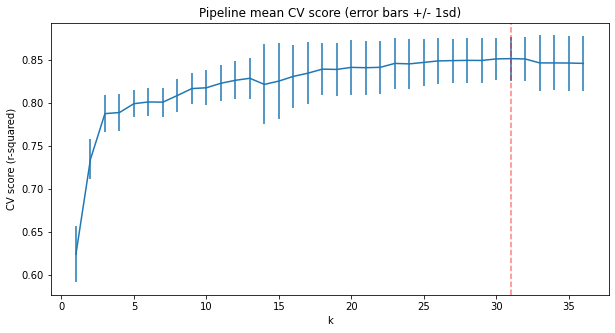

In [77]:
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

The above suggests a good value for k is 31. There was an initial rapid increase with k, followed by a slow decline. Also noticeable is the variance of the results increase above k=31. If overfitting, expect greater swings in performance as different points move in and out of the train/test folds.

Stepping into the best model, shown below, start with the fitted grid search object, getting the best estimator, then the named step 'selectkbest', that has the get_support() method for a logical mask of the features selected.

In [78]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

Similarly, instead of using the 'selectkbest' named step, access the named step for linear regression model and grab the model coefficients via its coef_ attribute:

In [79]:
#Get the linear model coefficients from `coef_` attribute and store in `coefs`, get matching feature names from column names
#of the dataframe, and display results as a pandas Series with `coefs` as values and `features` as index, sorting values in
#descending order
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

2ndFlrSF         6.619676e+16
1stFlrSF         5.456105e+16
LowQualFinSF     6.430305e+15
OverallQual      1.910542e+04
TotalBsmtSF      1.161492e+04
BsmtFinSF1       9.447353e+03
YearBuilt        8.367723e+03
MasVnrArea       6.340451e+03
OverallCond      4.943373e+03
LotArea          4.728041e+03
LotFrontage      4.397721e+03
YearRemodAdd     3.786809e+03
GarageYrBlt      3.603370e+03
PoolArea         2.889067e+03
GarageCars       2.836314e+03
TotRmsAbvGrd     2.688498e+03
WoodDeckSF       1.886600e+03
GarageArea       1.459957e+03
Fireplaces       1.418775e+03
EnclosedPorch    4.530928e+02
BsmtFullBath     4.429778e+02
OpenPorchSF      3.730286e+02
ScreenPorch      3.178545e+02
MoSold           1.937886e+02
BsmtUnfSF       -7.668708e+01
FullBath        -1.710529e+03
KitchenAbvGr    -2.573450e+03
HalfBath        -3.064189e+03
MSSubClass      -4.202915e+03
BedroomAbvGr    -1.099629e+04
GrLivArea       -7.599751e+16
dtype: float64

Results suggest 2nd Floor Sq. Ft. is the biggest positive feature. This makes intuitive sense and is consistent with the EDA work. Also, the 1st Floor Sq. Ft. is a strong positive. The GrLivArea is negatively associated with housing price. This seems odd. There could be all manner of reasons for this. It could be an effect whereby larger areas may be in less dense parts of Ames. Bear in mind, the coefficient for GrLivArea is negative for this model. For example, if the 1st and 2nd Floor Sq. Ft.was constant, but increased the GrLivArea, the housing price is cheaper.

Random Forest Model: A model works in a lot of cases. For regression, this is provided by sklearn's RandomForestRegressor class.

Time to stop the bad practice of repeatedly checking performance on the test split. Instead, go straight from defining the pipeline to assessing performance using cross-validation. cross_validate will perform the fitting as part of the process. This uses the default settings for the random forest to then proceed to investigate some different hyperparameters.

In [80]:
#Define a pipeline comprising the steps:
#SimpleImputer() with a strategy of 'median'
#StandardScaler(), and then RandomForestRegressor() with a random state of 47
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [81]:
#Fit and assess performance using cross-validation:
#Call `cross_validate` to estimate pipeline's performance. Pass it random forest pipe object, `X_train` and `y_train`,
#and get it to use 5-fold cross-validation
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [82]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.86705151, 0.85192393, 0.84508615, 0.87512725, 0.91887461])

In [83]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.8716126901728429, 0.02591582552473349)

Hyperparameter search using GridSearchCV

Random forest has a number of hyperparameters that can be explored, however here you'll limit yourselves to exploring some different values for the number of trees. You'll try it with and without feature scaling, and try both the mean and median as strategies for imputing missing values.

In [84]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

In [85]:
#Call `GridSearchCV` with random forest pipeline, passing in above `grid_params`
#dict for parameters to evaluate, 5-fold cross-validation, and all available CPU cores (if desired)
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [86]:
#Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. This may take a minute or two.
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'simpleimputer__strategy': [

In [87]:
#Print the best params (`best_params_` attribute) from the grid search
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 183,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

It looks like imputing with the median helps, but scaling the features doesn't.

In [88]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.87346499, 0.86134141, 0.85281998, 0.87231277, 0.92138747])

In [89]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.8762653229988719, 0.02379865414944481)

You've marginally improved upon the default CV results. Random forest has many more hyperparameters you could tune, but we won't dive into that here.

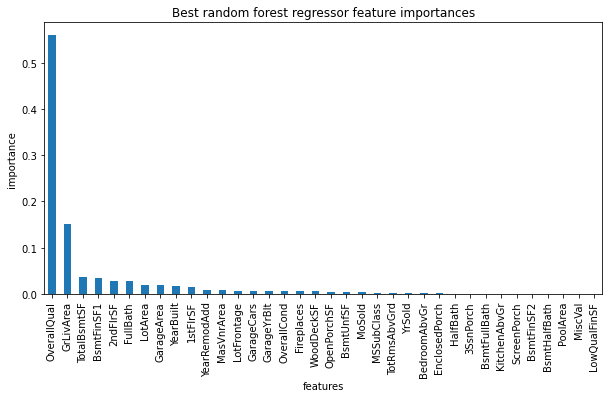

In [90]:
#Plot a barplot of random forest's feature importances, assigning `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to create a pandas Series object of 
#feature importances, with the index given by the training data column names, sorting the values in descending order
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

Encouragingly, the dominant top four features are in common with your linear model:

- fastQuads
- Runs
- Snow Making_ac
- vertical_drop

Final Model Selection:

It would be good to revisit the above model selection; there is more that could be done to explore possible hyperparameters. It is also worthwhile to investigate removing least useful features. Gathering or calculating, and storing, features adds business cost and dependencies, so if features genuinely are not needed they should be removed. Building a simpler model with fewer features can also have the advantage of being easier to sell (or explain) to stakeholders. There seem to be 4 strong features here and so a model using only those would probably work well. However, to explore some different scenarios where other features vary so keep the fuller model for now. The business is waiting for this model and the confidence to be much better than guessing with the average price.

There are two "somethings" in the best linear model and a best random forest model. Now to finally choose between them. Calculate the mean absolute error using cross-validation. Although cross-validate defaults to the $R^2$ metric for scoring regression, specify the mean absolute error as an alternative via the scoring parameter.

In [91]:
# 'neg_mean_absolute_error' uses the (negative of) the mean absolute error
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [92]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(20236.184167793217, 912.2036125818454)

In [93]:
mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

24541.60017433807

Random forest regression model performance

In [94]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [95]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(17575.102538566272, 1147.1374595736734)

In [96]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

19753.13517728373

Conclusion:
The random forest model has a lower cross-validation mean absolute error by almost \$1. It also exhibits less variability. Verifying performance on the test set produces performance consistent with the cross-validation results.

Data quantity assessment:

Finally, to advise the business whether it needs to undertake further data collection. Is more data be useful? Often led to believe more data is always good, but gathering data invariably has a cost associated with it. Assess the trade off by seeing how performance varies with differing data set sizes. The learning_curve function does this conveniently.

In [97]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

C:\Users\Process Research\Documents\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Process Research\Documents\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Process Research\Documents\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Process Research\Documents\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\Process Research\Documents\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\Process Research\Documen

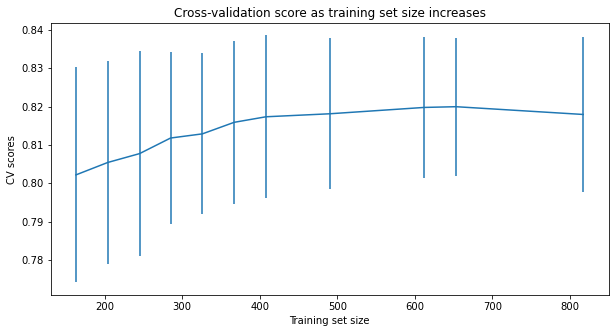

In [98]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

This shows that you seem to have plenty of data. There's an initial rapid improvement in model scores, but it essentially levelled off by around a sample size of 350-400.

In [99]:
#This may not be "production grade ML deployment" practice, but adding basic information to saved models can save bacon in 
#development. Just what version model should be loaded to reuse? What version of `sklearn` created it? When was it made? 
#Assign the pandas version number (`pd.__version__`) to the `pandas_version` attribute, the numpy version (`np.__version__`)
#to the `numpy_version` attribute, the sklearn version (`sklearn_version`) to the `sklearn_version` attribute, and the 
#current datetime (`datetime.datetime.now()`) to the `build_datetime` attribute. Let's call this model version '1.0'
best_model = rf_grid_cv.best_estimator_
best_model.version = 1.0
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()
    
modelpath = '../models'
if not os.path.exists(modelpath):
    os.mkdir(modelpath)
model_path = os.path.join(modelpath, 'Ames_housing_pricing_model.pkl')
if not os.path.exists(skimodel_path):
    with open(model_path, 'wb') as f:
        pickle.dump(best_model, f)

NameError: name 'skimodel_path' is not defined

Summary

Q: Write a summary of the work in this notebook. Capture the fact that you gained a baseline idea of performance by simply taking the average price and how well that did. Then highlight that you built a linear model and the features that found. Comment on the estimate of its performance from cross-validation and whether its performance on the test split was consistent with this estimate. Also highlight that a random forest regressor was tried, what preprocessing steps were found to be best, and again what its estimated performance via cross-validation was and whether its performance on the test set was consistent with that. State which model you have decided to use going forwards and why. This summary should provide a quick overview for someone wanting to know quickly why the given model was chosen for the next part of the business problem to help guide important business decisions.

A: When initially starting this unit, it felt like a trial by fire, however as I learned the difference between the X being attributes pertaining to house prices, Y being the actual price it is being compared to, and the difference in a test set and training, it started to slowly come together. The Random Forest Regression seemed to perform better relative to the linear regression, although it makes sense to always compare both for each business case rather than assuming that will always be the case.